This notebook tests whether the APE signal resumes where is left off the day before (or lower)

In [1]:
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from set_global_params import processed_data_path, change_over_time_mice, reproduce_figures_path, spreadsheet_path
from utils.stats import cohen_d_one_sample

In [4]:
# load all APE contra values
# requires ED_figure6/movement_vs_trial_num_regression/get_regression_slopes_for_turn_angle_speed_trial_number_vs_APE.py
# this is beacuse it aso requires all of the trials throughout training - no point generating again
# currently need python 3.6 and older pandas version to original read pickles - this is why the repro files are now csvs to deal with issue
mice = change_over_time_mice['tail']
for i, mouse in enumerate(mice):
    df_save_dir = r'{}{}\turn_angle_over_time'.format(processed_data_path, mouse)
    df_save_file = os.path.join(df_save_dir, 'movement_params_all_trials_vs_APE_{}.pkl'.format(mouse))
    repro_file_name = os.path.join(reproduce_figures_path, 'ED_fig6', 'all_trials_APE_{}.csv'.format(mouse))
    if not os.path.exists(repro_file_name):
        valid_contra_data = pd.read_pickle(df_save_file)
        sorted_data = valid_contra_data.sort_values(by='actual trial numbers').reset_index(drop=True)
        just_data_for_fig = sorted_data[['actual trial numbers', 'date', 'APE peaks', 'outcome', 'side', 'reaction times', 'choice numeric']]
        just_data_for_fig.to_csv(repro_file_name)
        sorted_data = just_data_for_fig
    else:
        sorted_data = pd.read_csv(repro_file_name)
    sessions = sorted_data.date.unique()
    for ii, session in enumerate(sessions):
        session_data = sorted_data[sorted_data.date == session]
        first_trials = session_data.iloc[0:40]['APE peaks'].mean()
        last_trials = session_data.iloc[-41:-1]['APE peaks'].mean()
        if ii == 0:
            beginning_and_end_all_sessions = pd.DataFrame({'mouse': [mouse], 'date': [session], 'recording number': [ii], 'first trial': [first_trials],
                                                          'last trial': [last_trials]})
        else:
            beginning_and_end = pd.DataFrame({'mouse': [mouse], 'date': [session], 'recording number': [ii], 'first trial': [first_trials],
                                                          'last trial': [last_trials]})
            beginning_and_end_all_sessions = pd.concat([beginning_and_end_all_sessions, beginning_and_end])
    beginning_and_end_all_sessions['end of last session'] = beginning_and_end_all_sessions['last trial'].shift(1)
    beginning_and_end_all_sessions['within \n session'] = beginning_and_end_all_sessions['last trial'] - beginning_and_end_all_sessions['first trial'] 
    beginning_and_end_all_sessions['between \n sessions'] = beginning_and_end_all_sessions['first trial'] - beginning_and_end_all_sessions['end of last session'] 
    
    df_for_test = beginning_and_end_all_sessions
    #print(ttest_rel(df_for_test['first trial'], df_for_test['end of last session']))
    if i == 0: 
        df_for_test_all_mice =  df_for_test
    else: 
        df_for_test_all_mice = pd.concat([df_for_test_all_mice, df_for_test])

In [6]:
per_mouse_df = df_for_test_all_mice.groupby(['mouse'])['between \n sessions', 'within \n session'].apply(np.mean)

C:\Users\francescag\AppData\Local\Temp\ipykernel_9592\4092735539.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  per_mouse_df = df_for_test_all_mice.groupby(['mouse'])['between \n sessions', 'within \n session'].apply(np.mean)
C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [7]:
per_mouse_df.index

Index(['SNL_photo16', 'SNL_photo17', 'SNL_photo18', 'SNL_photo21',
       'SNL_photo22', 'SNL_photo26'],
      dtype='object', name='mouse')

In [8]:
ttest_1samp(per_mouse_df['between \n sessions'], 0)

Ttest_1sampResult(statistic=1.2545407043491155, pvalue=0.26509545812982227)

In [9]:
cohen_d_one_sample(per_mouse_df['between \n sessions'])

cohen d:  0.512164097867857


0.512164097867857

In [10]:
ttest_1samp(per_mouse_df['within \n session'], 0)

Ttest_1sampResult(statistic=-2.626135766496434, pvalue=0.046750513191381626)

In [11]:
cohen_d_one_sample(per_mouse_df['within \n session'])

cohen d:  -1.0721154371981758


-1.0721154371981758

In [12]:
melted_df = pd.melt(per_mouse_df.reset_index(), id_vars=['mouse'], value_vars=['between \n sessions', 'within \n session'], value_name='change in z-scored dopamine response', var_name='difference')

In [14]:
spreadsheet_filename = os.path.join(spreadsheet_path, 'ED_fig6', 'ED_fig6N_between_within.csv')
if not os.path.exists(spreadsheet_filename):
    melted_df.to_csv(spreadsheet_filename)

In [60]:
melted_df.columns

Index(['mouse', 'difference', 'change in z-scored dopamine response'], dtype='object')

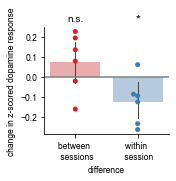

In [15]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42


sns.barplot(data=melted_df, x='difference', y='change in z-scored dopamine response', ax=ax, palette='Set1', errwidth=1, alpha=0.4)
sns.swarmplot(data=melted_df,x='difference', y='change in z-scored dopamine response', ax=ax, palette='Set1')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y = melted_df['change in z-scored dopamine response'].to_numpy().max() + 0.05
h = .1
ax.text(0, y, 'n.s.', ha='center', fontsize=10)
ax.text(1, y, '*', ha='center', fontsize=12)
ax.axhline(0, color='gray')
plt.tight_layout()